# **NEURAL NETWORK IN PYTORCH**

In [ ]:
# importing libraries and data

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from google.colab import files

SEED = 42
torch.manual_seed(SEED)

uploaded = files.upload()
training_data = pd.read_csv('train.csv')

Saving train.csv to train (2).csv


**First rendition of the neural network will just have depression score as the target variable**

In [ ]:
# defining X and Y variables
X = training_data.drop(columns=["Depression_Score", "Anxiety_Score"])
y = training_data["Depression_Score"]   # will use anxiety score later, in second rendition

# converting y to numpy for PyTorch implementation
y_np = y.values.astype(np.float32).reshape(-1, 1)

Accounting for categorical predictors and uncleaned numeric predictors with a preprocessing function

In [ ]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

# fits preprocessing only on the training fold, transforms both training and validation folds and prevents data leakage
# categorical encoding and scaling are the two main components of the preprocessing needed for our neural network
def preprocess_fold(X_tr, X_va, numeric_cols, categorical_cols):

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
        ]
    )

    # Fit on training set
    X_tr_processed = preprocessor.fit_transform(X_tr)

    # Transform validation set
    X_va_processed = preprocessor.transform(X_va)

    return (
        X_tr_processed.astype(np.float32),
        X_va_processed.astype(np.float32)
    )

Defining the PyTorch neural network architecture

In [ ]:
import torch.nn as nn

class MyModelNN(nn.Module):
    def __init__(self, in_dim, hidden_size=64):
        super().__init__()

        # A simple 3-layer fully-connected neural network
        self.fc1 = nn.Linear(in_dim, hidden_size) # using 'hidden_size' and not hard coding layer size to allow for hyperparameter tuning
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Creating a function to train and evaluate individual folds of the data

In [ ]:
import torch.optim as optim

# trains one neural network on a single CV fold using PyTorch, returns RMSE and R^2 for the validation fold
def train_one_fold(X_tr_processed, y_tr, X_va_processed, y_va, epochs=50, batch_size=64, lr=1e-3, hidden_size=64):

    # converts numpy arrays into tensors
    X_train_tensor = torch.tensor(X_tr_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_tr, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_va_processed, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_va, dtype=torch.float32)

    # builds training dataset and data loader
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # determine input dimension after preprocessing
    in_dim = X_tr_processed.shape[1]

    # instantiate the model
    model = MyModelNN(in_dim, hidden_size=hidden_size)

    # defining model loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam is the ideal optimizer for this dataset because of all the binary variables and the encoded ones

    # training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # validation loop
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_tensor).numpy().reshape(-1)
    y_true = y_va.reshape(-1)

    # computing evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return rmse, r2

Hyperparameter tuning

In [ ]:
learning_rates = [1e-3, 1e-2]
hidden_sizes = [32, 64, 128]
num_epochs = [20, 50, 100]

best_rmse = float("inf")
best_params = None

results_depression = []

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for lr in learning_rates:
    for hidden in hidden_sizes:
        for ep in num_epochs:

            fold_rmses = []

            for tr_idx, va_idx in kf.split(X):

                X_tr = X.iloc[tr_idx]
                X_va = X.iloc[va_idx]
                y_tr = y_np[tr_idx]
                y_va = y_np[va_idx]

                X_tr_processed, X_va_processed = preprocess_fold(
                    X_tr, X_va, numeric_cols, categorical_cols
                )

                rmse, r2 = train_one_fold(
                    X_tr_processed,
                    y_tr,
                    X_va_processed,
                    y_va,
                    lr=lr,
                    hidden_size=hidden,
                    epochs=ep
                )

                fold_rmses.append(rmse)

            avg_rmse = np.mean(fold_rmses)

            print(f"lr={lr}, hidden={hidden}, epochs={ep} → Avg RMSE = {avg_rmse:.4f}")

            # append results to the table list
            results_depression.append({
                "learning_rate": lr,
                "hidden_size": hidden,
                "epochs": ep,
                "avg_rmse": avg_rmse
            })

            # track best
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = (lr, hidden, ep)

results_depression_df = pd.DataFrame(results_depression)
results_depression_df.to_csv("nn_depression_tuning_results.csv", index=False)


lr=0.001, hidden=32, epochs=20 → Avg RMSE = 5.8241
lr=0.001, hidden=32, epochs=50 → Avg RMSE = 5.9096
lr=0.001, hidden=32, epochs=100 → Avg RMSE = 6.0894
lr=0.001, hidden=64, epochs=20 → Avg RMSE = 5.8358
lr=0.001, hidden=64, epochs=50 → Avg RMSE = 5.9784
lr=0.001, hidden=64, epochs=100 → Avg RMSE = 6.3431
lr=0.001, hidden=128, epochs=20 → Avg RMSE = 5.8837
lr=0.001, hidden=128, epochs=50 → Avg RMSE = 6.1264
lr=0.001, hidden=128, epochs=100 → Avg RMSE = 7.1107
lr=0.01, hidden=32, epochs=20 → Avg RMSE = 6.2851
lr=0.01, hidden=32, epochs=50 → Avg RMSE = 7.2235
lr=0.01, hidden=32, epochs=100 → Avg RMSE = 8.6148
lr=0.01, hidden=64, epochs=20 → Avg RMSE = 6.7021
lr=0.01, hidden=64, epochs=50 → Avg RMSE = 8.0445
lr=0.01, hidden=64, epochs=100 → Avg RMSE = 8.6708
lr=0.01, hidden=128, epochs=20 → Avg RMSE = 7.1661
lr=0.01, hidden=128, epochs=50 → Avg RMSE = 7.9784
lr=0.01, hidden=128, epochs=100 → Avg RMSE = 8.1740


In [ ]:
print("\nBEST HYPERPARAMETERS FOUND:")
print(f"Learning Rate = {best_params[0]}")
print(f"Hidden Size = {best_params[1]}")
print(f"Epochs = {best_params[2]}")
print("Best RMSE =", best_rmse)


BEST HYPERPARAMETERS FOUND:
Learning Rate = 0.001
Hidden Size = 32
Epochs = 20
Best RMSE = 5.824078949746927


Final step, training final neural network using tuned hyperparameters

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

rmse_scores = []
r2_scores = []

# outer cross validation loop, using best parameters and training that model on each fold, then collecting evaluation metrics and averaging them across the folds
for tr_idx, va_idx in kf.split(X):

    # Split predictors
    X_tr = X.iloc[tr_idx]
    X_va = X.iloc[va_idx]

    # Split targets
    y_tr = y_np[tr_idx]
    y_va = y_np[va_idx]

    # Preprocess fold (scale numeric + one-hot encode categorical)
    X_tr_processed, X_va_processed = preprocess_fold(
        X_tr,
        X_va,
        numeric_cols,
        categorical_cols
    )

    # Train and evaluate NN on this fold
    rmse, r2 = train_one_fold(
      X_tr_processed,
      y_tr,
      X_va_processed,
      y_va,
      lr=best_params[0],
      hidden_size=best_params[1],
      epochs=best_params[2]
    )

    # Store results
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Summary of results across all 5 folds
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

Average RMSE: 5.8079 ± 0.1453
Average R²:   -0.0584 ± 0.0407


Generating plot showing predictive ability of neural network

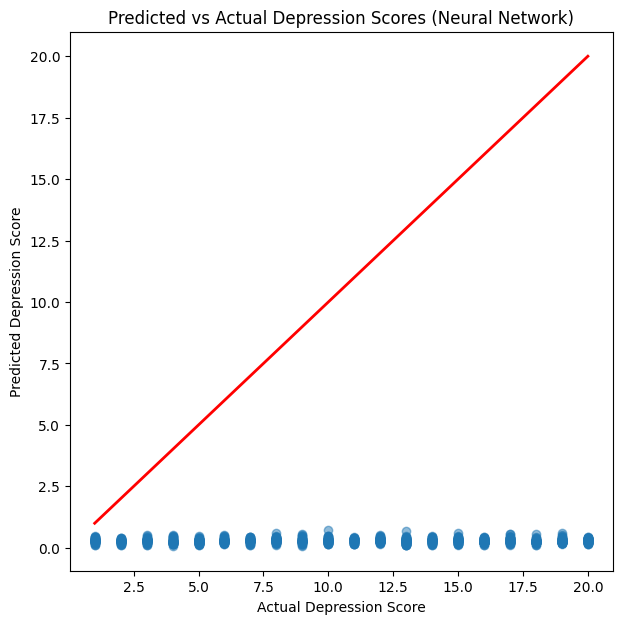

In [ ]:
import matplotlib.pyplot as plt

# Re-train a final model on the full dataset using best hyperparameters
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)
preprocessor.fit(X)
X_processed = preprocessor.transform(X)

in_dim = X_processed.shape[1]
final_model = MyModelNN(in_dim, hidden_size=best_params[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[0])

X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.float32)

# Train final model
for epoch in range(best_params[2]):
    optimizer.zero_grad()
    preds = final_model(X_tensor)
    loss = criterion(preds, y_tensor)
    loss.backward()
    optimizer.step()

# Get predictions
with torch.no_grad():
    y_pred = final_model(X_tensor).numpy().reshape(-1)

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_np, y_pred, alpha=0.5)
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], color="red", linewidth=2)
plt.xlabel("Actual Depression Score")
plt.ylabel("Predicted Depression Score")
plt.title("Predicted vs Actual Depression Scores (Neural Network)")

# Save plot
plt.savefig(f"nn_predictions_depression.png", dpi=300)

plt.show()

**Rerunning the analysis with anxiety score as the target variable**

First just setting anxiety score as the target

In [ ]:
y = training_data["Anxiety_Score"]
y_np = y.values.astype(np.float32).reshape(-1, 1)

Doing hyperparameter tuning again for anxiety score

In [ ]:
learning_rates = [1e-3, 1e-2]
hidden_sizes = [32, 64, 128]
num_epochs = [20, 50, 100]

best_rmse = float("inf")
best_params = None

results_anxiety = []

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

for lr in learning_rates:
    for hidden in hidden_sizes:
        for ep in num_epochs:

            fold_rmses = []

            for tr_idx, va_idx in kf.split(X):

                X_tr = X.iloc[tr_idx]
                X_va = X.iloc[va_idx]
                y_tr = y_np[tr_idx]
                y_va = y_np[va_idx]

                X_tr_processed, X_va_processed = preprocess_fold(
                    X_tr, X_va, numeric_cols, categorical_cols
                )

                rmse, r2 = train_one_fold(
                    X_tr_processed,
                    y_tr,
                    X_va_processed,
                    y_va,
                    lr=lr,
                    hidden_size=hidden,
                    epochs=ep
                )

                fold_rmses.append(rmse)

            avg_rmse = np.mean(fold_rmses)

            print(f"lr={lr}, hidden={hidden}, epochs={ep} → Avg RMSE = {avg_rmse:.4f}")

            # append results to the table list
            results_anxiety.append({
                "learning_rate": lr,
                "hidden_size": hidden,
                "epochs": ep,
                "avg_rmse": avg_rmse
            })

            # track best
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = (lr, hidden, ep)

results_anxiety_df = pd.DataFrame(results_anxiety)
results_anxiety_df.to_csv("nn_anxiety_tuning_results.csv", index=False)


lr=0.001, hidden=32, epochs=20 → Avg RMSE = 6.0351
lr=0.001, hidden=32, epochs=50 → Avg RMSE = 6.1023
lr=0.001, hidden=32, epochs=100 → Avg RMSE = 6.3030
lr=0.001, hidden=64, epochs=20 → Avg RMSE = 6.0839
lr=0.001, hidden=64, epochs=50 → Avg RMSE = 6.1778
lr=0.001, hidden=64, epochs=100 → Avg RMSE = 6.6304
lr=0.001, hidden=128, epochs=20 → Avg RMSE = 6.1107
lr=0.001, hidden=128, epochs=50 → Avg RMSE = 6.3531
lr=0.001, hidden=128, epochs=100 → Avg RMSE = 7.3933
lr=0.01, hidden=32, epochs=20 → Avg RMSE = 6.6615
lr=0.01, hidden=32, epochs=50 → Avg RMSE = 7.5943
lr=0.01, hidden=32, epochs=100 → Avg RMSE = 9.1194
lr=0.01, hidden=64, epochs=20 → Avg RMSE = 6.7939
lr=0.01, hidden=64, epochs=50 → Avg RMSE = 8.5463
lr=0.01, hidden=64, epochs=100 → Avg RMSE = 9.1294
lr=0.01, hidden=128, epochs=20 → Avg RMSE = 7.5216
lr=0.01, hidden=128, epochs=50 → Avg RMSE = 8.3126
lr=0.01, hidden=128, epochs=100 → Avg RMSE = 8.3454


In [ ]:
print("\nBEST HYPERPARAMETERS FOUND:")
print(f"Learning Rate = {best_params[0]}")
print(f"Hidden Size = {best_params[1]}")
print(f"Epochs = {best_params[2]}")
print("Best RMSE =", best_rmse)


BEST HYPERPARAMETERS FOUND:
Learning Rate = 0.001
Hidden Size = 32
Epochs = 20
Best RMSE = 6.035144014718547


Training neural network for anxiety score using tuned hyperparameters

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

rmse_scores = []
r2_scores = []

for tr_idx, va_idx in kf.split(X):

    # Split predictors
    X_tr = X.iloc[tr_idx]
    X_va = X.iloc[va_idx]

    # Split targets
    y_tr = y_np[tr_idx]
    y_va = y_np[va_idx]

    # Preprocess fold (scale numeric + one-hot encode categorical)
    X_tr_processed, X_va_processed = preprocess_fold(
        X_tr,
        X_va,
        numeric_cols,
        categorical_cols
    )

    # Train and evaluate NN on this fold
    rmse, r2 = train_one_fold(
        X_tr_processed,
        y_tr,
        X_va_processed,
        y_va
    )

    # Store results
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Summary of results across all 5 folds
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average R²:   {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

Average RMSE: 6.1495 ± 0.2180
Average R²:   -0.0811 ± 0.0494


Generating plot showing predictive ability of neural network

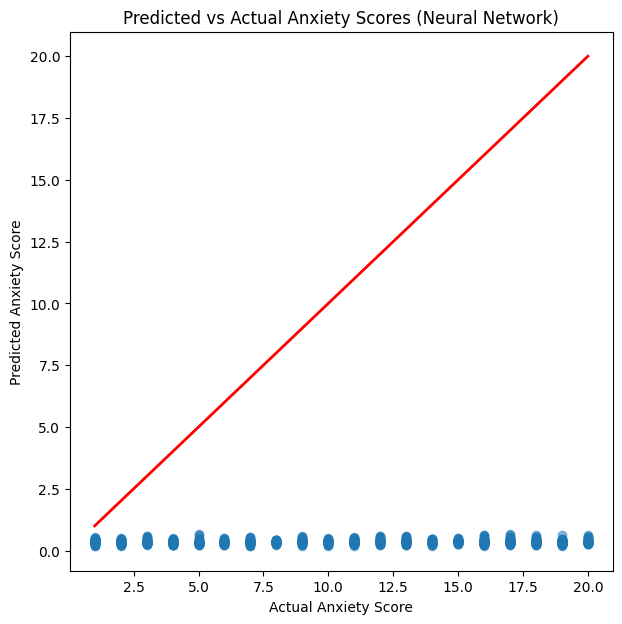

In [ ]:
import matplotlib.pyplot as plt

# Re-train a final model on the full dataset using best hyperparameters
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)
preprocessor.fit(X)
X_processed = preprocessor.transform(X)

in_dim = X_processed.shape[1]
final_model = MyModelNN(in_dim, hidden_size=best_params[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params[0])

X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.float32)

# Train final model
for epoch in range(best_params[2]):
    optimizer.zero_grad()
    preds = final_model(X_tensor)
    loss = criterion(preds, y_tensor)
    loss.backward()
    optimizer.step()

# Get predictions
with torch.no_grad():
    y_pred = final_model(X_tensor).numpy().reshape(-1)

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(y_np, y_pred, alpha=0.5)
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], color="red", linewidth=2)
plt.xlabel("Actual Anxiety Score")
plt.ylabel("Predicted Anxiety Score")
plt.title("Predicted vs Actual Anxiety Scores (Neural Network)")

# Save plot
plt.savefig(f"nn_predictions_anxiety.png", dpi=300)

plt.show()